# Introduction.

These are some (modest) attempts at participating in Jigsaw's toxic comments classification problem. For now, I am not using any external data, only the training data given (which is limiting as it's a tiny dataset).

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import gensim
import keras
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re
import string
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import h5py
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import pickle 

# Load Data

In [4]:
df = pd.read_csv('../data/toxicity_annotated_comments.tsv', sep='\t')

In [5]:
df.head()

,rev_id,comment,year,logged_in,ns,sample,split
0,2232.0,This:NEWLINE_TOKEN:One can make an analogy in ...,2002,True,article,random,train
1,4216.0,`NEWLINE_TOKENNEWLINE_TOKEN:Clarification for ...,2002,True,user,random,train
2,8953.0,Elected or Electoral? JHK,2002,False,article,random,test
3,26547.0,`This is such a fun entry. DevotchkaNEWLINE_...,2002,True,article,random,train
4,28959.0,Please relate the ozone hole to increases in c...,2002,True,article,random,test


In [6]:
len(df)

159686

In [7]:
scores = pd.read_csv('../data/toxicity_annotations.tsv',  sep='\t')

In [8]:
scores.head(10)

,rev_id,worker_id,toxicity,toxicity_score
0,2232.0,723,0,0.0
1,2232.0,4000,0,0.0
2,2232.0,3989,0,1.0
3,2232.0,3341,0,0.0
4,2232.0,1574,0,1.0
5,2232.0,1508,0,1.0
6,2232.0,772,0,1.0
7,2232.0,680,0,0.0
8,2232.0,405,0,1.0
9,2232.0,4020,1,-1.0


In [9]:
scores.drop_duplicates(subset='rev_id', inplace=True)

In [10]:
len(scores)

159686

In [11]:
df = df.merge(scores, on='rev_id', how='inner')

In [12]:
len(df)

159686

In [13]:
df.head(10)

,rev_id,comment,year,logged_in,ns,sample,split,worker_id,toxicity,toxicity_score
0,2232.0,This:NEWLINE_TOKEN:One can make an analogy in ...,2002,True,article,random,train,723,0,0.0
1,4216.0,`NEWLINE_TOKENNEWLINE_TOKEN:Clarification for ...,2002,True,user,random,train,500,0,0.0
2,8953.0,Elected or Electoral? JHK,2002,False,article,random,test,2596,0,1.0
3,26547.0,`This is such a fun entry. DevotchkaNEWLINE_...,2002,True,article,random,train,1642,0,1.0
4,28959.0,Please relate the ozone hole to increases in c...,2002,True,article,random,test,202,0,1.0
5,35367.0,`:In an interpreted language your source code ...,2002,True,article,random,dev,1408,0,1.0
6,37330.0,`NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKENI fixe...,2002,True,article,random,train,691,0,0.0
7,37346.0,`If they are ``indisputable`` then why does th...,2002,True,article,random,train,1108,0,0.0
8,37675.0,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,dev,403,0,1.0
9,44377.0,`NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKENThe co...,2002,True,article,random,train,1927,0,2.0


In [14]:
df.drop(columns=['year', 'logged_in', 'split', 'ns', 'sample', 'worker_id'], inplace=True)

In [15]:
df.head(10)

,rev_id,comment,toxicity,toxicity_score
0,2232.0,This:NEWLINE_TOKEN:One can make an analogy in ...,0,0.0
1,4216.0,`NEWLINE_TOKENNEWLINE_TOKEN:Clarification for ...,0,0.0
2,8953.0,Elected or Electoral? JHK,0,1.0
3,26547.0,`This is such a fun entry. DevotchkaNEWLINE_...,0,1.0
4,28959.0,Please relate the ozone hole to increases in c...,0,1.0
5,35367.0,`:In an interpreted language your source code ...,0,1.0
6,37330.0,`NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKENI fixe...,0,0.0
7,37346.0,`If they are ``indisputable`` then why does th...,0,0.0
8,37675.0,`-NEWLINE_TOKENThis is not ``creative``. Thos...,0,1.0
9,44377.0,`NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKENThe co...,0,2.0


In [16]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def mr_clean(comment):
    comment = re.sub('NEWLINE_TOKEN', '', comment)
    comment = re_tok.sub('', comment)             # remove punctuation
    comment = re.sub('_', ' ', comment)
    comment = re.sub( '\s+', ' ', comment)
    comment = comment.strip()
    return comment

In [17]:
df['comment'] = df['comment'].apply(mr_clean)

### Get all the words mapped into a dictionary

In [18]:
#Get the unique words 
from collections import Counter
def find_all_unique_words_with_frequency(corpora):
    bag_of_words_universe = []
    for mysentence in corpora:
        bag_of_words = mysentence.lower().split()
        bag_of_words = [x.strip() if (len(x) < 30) else x[:30] for x in bag_of_words ]
        bag_of_words_universe.extend(bag_of_words)
    word_frequency = Counter(bag_of_words_universe)
    return word_frequency

corpora = df['comment'].values
word_freq_dict = find_all_unique_words_with_frequency(corpora)


In [19]:
word_freq_df = word_freq_dict.most_common()
word_freq_df = pd.DataFrame(word_freq_df, columns = ['word', 'freq'], index = None)
word_freq_df.to_csv('../data/word_frequency.csv', index=False)

In [20]:
#Create a list of profane words 
badlist = pd.read_table('../data/profane_list.txt', header=None, comment = '#', encoding='utf-8')
badlist = badlist.values.flatten()
badlist

array(['2 girls 1 cup', '2g1c', '4r5e', ..., 'zigabo', 'zipperhead',
       'zoophilia'], dtype=object)

In [21]:
#Assuming that the data with freq 50 will be most frequent. 
most_frequent_words = [k for k,v in word_freq_dict.items() if v >= 25]
print(most_frequent_words)
least_frequent_words = [k for k,v in word_freq_dict.items() if v < 25]
print(least_frequent_words)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [22]:
import enchant
import time 
from datetime import datetime 

def divide_into_known_and_difficult(least_frequent_words, badlist):
    difficult_words = []
    known_words = []
    d = enchant.Dict("en_US")  
    i = 0
    tic = time.time()
    for a_word in least_frequent_words:
        if i% 100000 == 0:
            toc = time.time()
            print ('Number of commnets done = ', i, ',   time = ', toc-tic)
            tic = toc
        i += 1
        if (d.check(a_word) or (a_word in badlist)):
            known_words.append(a_word)
        else:
            difficult_words.append(a_word)
    return known_words, difficult_words

In [23]:
known_words, difficult_words = divide_into_known_and_difficult(least_frequent_words, badlist)

Number of commnets done =  0 ,   time =  1.6689300537109375e-06
Number of commnets done =  100000 ,   time =  6.963977336883545
Number of commnets done =  200000 ,   time =  8.110761880874634


In [24]:
#Start creating the dictionary
my_mapped_dictionary = {}
for a_word in most_frequent_words:
    my_mapped_dictionary[a_word] = a_word
for a_word in known_words:
    my_mapped_dictionary[a_word] = a_word
len(my_mapped_dictionary)

55532

In [25]:
len(difficult_words)

239509

In [26]:
from fuzzywuzzy import process

def containsAny(seq, aset):
    return bool(set(aset).intersection(seq))

def find_mapping_for_difficult_word(myword, badlist):
    myword_len = len(myword)
    found_toxic_word = 0
    #If the word is a number, replace with 'number'
    if myword.isnumeric():
        return ':number:'#, found_toxic_word
    #Get fuzzy matches to the word
    matches = process.extract(myword, badlist)
    if myword_len == 30:
        if matches[0][1] > 75: #Matching percent more than 75
            found_toxic_word = 1
            return matches[0][0]#, found_toxic_word            
    #If string contains any of the following characters then try to map to the closest 
    if containsAny(myword, {'!', '@', '#', '$', '%', '^', '&', '*'}):
        closest_match = matches[0]
        for tup in matches[:5]:
            if len(tup[0]) == len(myword):
                closest_match = tup
                break
        new_word =   closest_match[0]
        found_toxic_word = 1
        return new_word#, found_toxic_word            
    #If everything fails. Keep as is 
    return myword#, found_toxic_word

def find_mapping_for_difficult_word_wrapper(difficult_words, badlist):
    i = 0
    tic = time.time()
    for word in difficult_words:
        if i% 1000 == 0:
            toc = time.time()
            print ('Number of commnets done = ', i, ',   time = ', toc-tic)
            tic = toc
        i += 1
        new_word = find_mapping_for_difficult_word(word, badlist)
        my_mapped_dictionary[word] = new_word
    return (my_mapped_dictionary)

#### Uncomment if you want to rerun this cell. It takes about 5 hours to run on my system. 

In [28]:
# my_mapped_dictionary = find_mapping_for_difficult_word_wrapper(difficult_words, badlist)
# pickle.dump(my_mapped_dictionary, open( '../data/word_map_dictionary.pkl', "wb" ) )

In [29]:
my_mapped_dictionary = pickle.load( open( '../data/word_map_dictionary.pkl', "rb" ) )

In [30]:
my_mapped_dictionary

{'can': 'can',
 'make': 'make',
 'an': 'an',
 'analogy': 'analogy',
 'in': 'in',
 'mathematical': 'mathematical',
 'terms': 'terms',
 'by': 'by',
 'the': 'the',
 'distribution': 'distribution',
 'of': 'of',
 'opinions': 'opinions',
 'a': 'a',
 'population': 'population',
 'as': 'as',
 'curve': 'curve',
 'we': 'we',
 'would': 'would',
 'then': 'then',
 'say': 'say',
 'that': 'that',
 'consensus': 'consensus',
 'be': 'be',
 'statement': 'statement',
 'represents': 'represents',
 'range': 'range',
 'within': 'within',
 'perhaps': 'perhaps',
 'three': 'three',
 'standard': 'standard',
 'mean': 'mean',
 'opinion': 'opinion',
 'sounds': 'sounds',
 'arbitrary': 'arbitrary',
 'and': 'and',
 'ad': 'ad',
 'hoc': 'hoc',
 'does': 'does',
 'it': 'it',
 'really': 'really',
 'belong': 'belong',
 'n': 'n',
 'encyclopedia': 'encyclopedia',
 'article': 'article',
 'i': 'i',
 'dont': 'dont',
 'see': 'see',
 'adds': 'adds',
 'anything': 'anything',
 'paragraph': 'paragraph',
 'follows': 'follows',
 'seems

In [84]:
i = 0
for k in my_mapped_dictionary:
    if k!=my_mapped_dictionary[k]:
        i = i+1 

In [85]:
i

1190

In [87]:
1190.0/len(my_mapped_dictionary)

0.0040333377395006115

### Now parse all the comments. one comment at a time 

In [31]:
import enchant

def find_mapped_word(myword, badlist):
    d = enchant.Dict("en_US")
    #Check if toxic word or found in dictionary
    if (myword in badlist) or (d.check(myword)):
        return myword
    #else call 
    corr_word = find_mapping_for_difficult_word(myword, badlist)
    return  corr_word

def curate_a_list_of_comments(list_of_comments, my_mapped_dictionary, badlist, new_mapping_dictionary):
    d = enchant.Dict("en_US")   
    print ('total number of comments  = ', len(list_of_comments))
    i = 0 
    tic = time.time()
    begtime = tic
    out_list_of_comments = []
    
    for mycomment in list_of_comments:
        #print (mycomment)
        if i% 30000 == 0:
            toc = time.time()
            print ('Number of commnets done = ', i, ',   time = ', toc-tic)
            tic = toc
        i += 1
        #Split into words and make it lower case
        mycomment_words = mycomment.lower().split()
        mycomment_words = [x.strip() if (len(x) < 30) else x[:30] for x in mycomment_words ]
        #Loop through each words
        converted_comment = []
        for myword in mycomment_words:
            try: 
                #Get corresponding word from mapping dictionary
                corr_word = my_mapped_dictionary[myword]
                converted_comment.append(corr_word)
            except:
                new_word = find_mapped_word(myword, badlist)
                new_mapping_dictionary[myword] = new_word
                converted_comment.append(new_word)
        converted_comment = ' '.join(converted_comment)
        out_list_of_comments.append(converted_comment)
    return out_list_of_comments, new_mapping_dictionary

In [32]:
# list_of_comments = ['i am leaving', 'fuck u ass*hole', '']
# new_mapping_dictionary = {}
# out_list_of_comments, new_mapping_dictionary = curate_a_list_of_comments(list_of_comments, my_mapped_dictionary, badlist, new_mapping_dictionary)

In [33]:
list_of_comments = df['comment'].values.tolist()
new_mapping_dictionary = {}
out_list_of_comments, new_mapping_dictionary = curate_a_list_of_comments(list_of_comments, my_mapped_dictionary, badlist, new_mapping_dictionary)

total number of comments  =  159686
Number of commnets done =  0 ,   time =  1.0013580322265625e-05
Number of commnets done =  30000 ,   time =  0.7951180934906006
Number of commnets done =  60000 ,   time =  0.7791118621826172
Number of commnets done =  90000 ,   time =  0.914949893951416
Number of commnets done =  120000 ,   time =  0.7819921970367432
Number of commnets done =  150000 ,   time =  0.7849538326263428


#### Update the word-map-dictionary

In [34]:
#Populate the mapping dictionary with newly found mapping dictionary.
updated_mapped_dictionary = {**my_mapped_dictionary, **new_mapping_dictionary}
mapped_filename =  '../data/word_map_dictionary_' + datetime.now().strftime("%Y%m%d_%H%M%S" + '.pkl')
pickle.dump(updated_mapped_dictionary, open(mapped_filename, "wb" ) )

### Update the dataframe with the converted comments 

In [35]:
#Update the 'comment' column in the dataframe 
df['comment'] = out_list_of_comments

In [36]:
df['toxic'] = df['toxicity_score'].apply(lambda x: int(x < 0))

In [37]:
df.drop(columns=['toxicity', 'toxicity_score'], inplace=True)

In [38]:
#df.sort_values(['toxic'], ascending=False, inplace=True)

In [39]:
df[df['toxic']==1].head(10)

,rev_id,comment,toxic
42,250290.0,ed i am tired anyway i certainly did not mean ...,1
86,608166.0,1 i dont think unreadable is that far off beam...,1
94,630630.0,on second thought why not instead provide a ne...,1
104,682829.0,youd think neonazis would have other business ...,1
122,749900.0,the macedonian origin name is monastirgreek na...,1
124,761965.0,nice work on this article folks,1
133,790462.0,sorry you send this message to the wrong user,1
142,856388.0,the protocols isnt a conspiracy theory it is a...,1
195,1171026.0,id be interested to know why this page discuss...,1
207,1245501.0,i was with you until the last paragraph which ...,1


# Train/Test Split

In [43]:
from sklearn.model_selection import train_test_split
y = df.toxic
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.1, random_state=101)

In [44]:
len(X_train)

143717

In [45]:
len(X_test)

15969

In [46]:
X_train.to_csv('../data/toxic_train.tsv', sep='\t')
X_test.to_csv('../data/toxic_test.tsv', sep='\t')

# Pre-process

In [47]:
simple_tokens = X_train.comment.apply(gensim.utils.simple_preprocess)

In [48]:
phrases = gensim.models.phrases.Phrases(simple_tokens)
tokenizer = gensim.models.phrases.Phraser(phrases)

In [49]:
tokenized_text = list(tokenizer[simple_tokens])

In [50]:
tokenized_text[0]

['ed_boon',
 'said',
 'in',
 'an_interview',
 'that',
 'there',
 'would',
 'be',
 'at_least',
 'characters',
 'however',
 'dont_think',
 'we',
 'can',
 'report',
 'this',
 'because',
 'that',
 'was',
 'an',
 'estimate',
 'in',
 'early',
 'development',
 'like',
 'in',
 'march',
 'or',
 'something']

In [51]:
corpus_dict = gensim.corpora.dictionary.Dictionary(tokenized_text)

In [52]:
X_train.columns

Index(['rev_id', 'comment', 'toxic'], dtype='object')

In [53]:
TARGET_CLASSES = ['toxic']
targets = X_train[TARGET_CLASSES].values

In [54]:
targets

array([[0],
       [0],
       [0],
       ..., 
       [0],
       [0],
       [0]])

# Analysis

(0, 400)

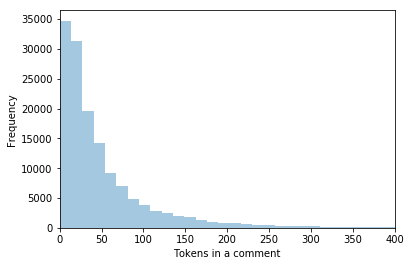

In [55]:
sns.distplot([len(doc) for doc in tokenized_text], bins=100, kde=False, label='Number of tokens per comment.')
plt.xlabel("Tokens in a comment")
plt.ylabel("Frequency")
plt.xlim((0, 400))

# Training word2vec on comment data.

In [56]:
word2vec = gensim.models.word2vec.Word2Vec(tokenized_text, window=5, size=100, min_count=2, workers=6)

In [57]:
word2vec.wv.most_similar('citation')

[('reference', 0.8486384153366089),
 ('source', 0.7971519827842712),
 ('verification', 0.7613769173622131),
 ('citations', 0.7610040307044983),
 ('references', 0.7443020343780518),
 ('ref', 0.7399541139602661),
 ('reliable_source', 0.7288672924041748),
 ('secondary_source', 0.728357195854187),
 ('footnote', 0.716575562953949),
 ('quote', 0.6909138560295105)]

In [58]:
word2vec.wv.most_similar('stupid')

[('dumb', 0.8389883041381836),
 ('pathetic', 0.8294868469238281),
 ('crazy', 0.8025041818618774),
 ('silly', 0.8001160621643066),
 ('ugly', 0.7900490760803223),
 ('retarded', 0.7869418859481812),
 ('lazy', 0.7713940143585205),
 ('lame', 0.7606254816055298),
 ('funny', 0.75559401512146),
 ('fucking', 0.7516430616378784)]

# word2vec-based model

Aggregate word embeddings per comment (~ tf-idf weighted averaging), and use that as an input feature in a neural net with one hidden layer.

In [59]:
features = np.zeros((len(tokenized_text), word2vec.vector_size))
for i, tokens in enumerate(tokenized_text):
    tokens = [t for t in tokens if t in word2vec.wv.vocab]
    if tokens:
        features[i, :] = np.mean([word2vec.wv[t] / word2vec.wv.vocab[t].count for t in tokens], axis=0)

In [60]:
#model = Sequential()
#model.add(Dense(256, activation='relu', input_shape=(word2vec.vector_size,)))
#model.add(Dense(128, activation='relu'))
#model.add(Dense(len(TARGET_CLASSES), activation='sigmoid'))
#model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [61]:
#model.fit(features, targets, epochs=10, validation_split=0.1)

# Sequential models

Simply averaging embeddings across all terms in a comment loses interactions that can occur between words, and the importance of their position. Because of this, we will now experiment with position-aware models: LSTM and CNN.

In [62]:
# Note: shifting indices by 1 as index 0 will be used for padding.
docs = [[idx + 1 for idx in corpus_dict.doc2idx(doc)]  for doc in tokenized_text]

In [63]:
MAX_SEQ_LEN = 50
padded_docs = keras.preprocessing.sequence.pad_sequences(docs, maxlen=MAX_SEQ_LEN, truncating='post', value=0)

In [64]:
max_idx = max(c for d in docs for c in d)
max_idx

239975

In [65]:
embeddings = np.array([np.random.normal(size=word2vec.vector_size)]+ # for the '0' padding word
                      [word2vec.wv[corpus_dict[idx]]
                      if corpus_dict[idx] in word2vec.wv.vocab
                      else np.random.normal(size=word2vec.vector_size)
                      for idx in range(max_idx)])

## CNN

In [66]:
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN
from keras.layers.core import Dense, Dropout
from keras.layers.wrappers import TimeDistributed
from keras.layers import Convolution1D, MaxPool1D, Flatten, BatchNormalization

model = Sequential()
model.add(Embedding(max_idx + 1, word2vec.vector_size, input_length=MAX_SEQ_LEN))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Convolution1D(52, 5, padding='same',
                        kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(MaxPool1D())
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Convolution1D(128, 3, padding='same',
                        kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(MaxPool1D())
model.add(Flatten())
model.add(Dense(len(TARGET_CLASSES), activation='sigmoid',
                kernel_regularizer=keras.regularizers.l2(0.02)))
model.compile(Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [67]:
model.fit(padded_docs, targets, batch_size=512, epochs=20, validation_split=0.1)

Train on 129345 samples, validate on 14372 samples
Epoch 1/20
129345/129345 [==============================] - 159s 1ms/step - loss: 0.7364 - acc: 0.8683 - val_loss: 0.4451 - val_acc: 0.8505
Epoch 2/20
129345/129345 [==============================] - 163s 1ms/step - loss: 0.2934 - acc: 0.9009 - val_loss: 0.4016 - val_acc: 0.8574
Epoch 3/20
129345/129345 [==============================] - 166s 1ms/step - loss: 0.2360 - acc: 0.9197 - val_loss: 0.3604 - val_acc: 0.8842
Epoch 4/20
129345/129345 [==============================] - 181s 1ms/step - loss: 0.1988 - acc: 0.9349 - val_loss: 0.3922 - val_acc: 0.8824
Epoch 5/20
129345/129345 [==============================] - 176s 1ms/step - loss: 0.1716 - acc: 0.9472 - val_loss: 0.4341 - val_acc: 0.8831
Epoch 6/20
129345/129345 [==============================] - 175s 1ms/step - loss: 0.1504 - acc: 0.9565 - val_loss: 0.4497 - val_acc: 0.8687
Epoch 7/20
129345/129345 [==============================] - 165s 1ms/step - loss: 0.1345 - acc: 0.9631 - val_

# Save Model

In [88]:
model.save_weights('models/cnn_model.h5')

In [ ]:
#model.load_weights('models/cnn_model.h5')

# Evaluation

In [70]:
def comment_to_sequential_input(comment):
    tokens = tokenizer[gensim.utils.simple_preprocess(comment)]
    t_ids = [corpus_dict.token2id[t] + 1 for t in tokens if t in word2vec.wv.vocab and t in corpus_dict.token2id]
    return keras.preprocessing.sequence.pad_sequences([t_ids], maxlen=MAX_SEQ_LEN)[0]

In [71]:
def predict(comment):
    test_input = [comment_to_sequential_input(comment).reshape(1, -1)]
    for target_class, score in zip(TARGET_CLASSES, model.predict(test_input)[0]):
        print("{}: {:.2f}%".format(target_class, score * 100))

In [72]:
comment = "Why are we having all these people from shithole countries come here?"
predict(comment)

toxic: 42.52%


In [73]:
comment = 'You suck, loser!'
predict(comment)

toxic: 98.59%


In [74]:
comment = "Now is the time for all good persons to come to the aid of their country"
predict(comment)

toxic: 7.19%


In [75]:
test_inputs = np.array([comment_to_sequential_input(doc) for doc in X_test.comment])

In [76]:
y_pred = model.predict_classes(test_inputs)

In [77]:
y_true = X_test.as_matrix(columns=['toxic'])

In [78]:
accuracy_score(y_true, y_pred)

0.86361074582002628

In [79]:
target_names = ['toxic']
print(classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

      toxic       0.90      0.94      0.92     13581

avg / total       0.85      0.86      0.85     15969



/Users/fmohamm/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 2, does not match size of target_names, 1
  .format(len(labels), len(target_names))
